# Regression Model - Wheat Calibration

Artificial Neural Network based on a TensorFlow / Keras model

**Training Data pre-treatment**:
- Load calibration data for training
- Only use pixels from 9 to 33 (25 pixels) for training
- Drop any rows with y values outside limits (e.g. 5-20% for protein in wheat)
- Fit the training data into Principal Component Analysis (PCA) from scikit-learn
- Transform the training data into principal components
- Use MinMaxScaler() to fit the data between (-1, 1)

**Validation Data pre-treatment**:
- Load validation data
- Only use pixels from 9 to 33 (25 pixels) for training
- Drop any rows with y values outside limits (e.g. 5-20% for protein in wheat)
- Transform the validation data into principal components using the PCA model from the training set
- Use MinMaxScaler() to fit the data between (-1, 1)

**Train Model in TensorFlow / Keras**:

After the data is ready for the neural network, create the model in Keras, compile it and fit it.

**Testing Data pre-treatment**:
- Same as validation data pre-treatment

**Check predictions and calculate slope and biases**

The training and validation data usually come from the master system whereas the testing data is usually the prediction made on other systems to check calibration transferability

### Import Libraries
`tensorflow`, `numpy`, `pandas`, `matplotlib`, `sklearn`

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

C:\Users\t\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Values for the data pre-processing stage. Chnage these values accordingly depending on the model

In [2]:
NumberOfConstituents = 2
Cal1Name = "Protein"
Cal1MinValue = 5
Cal1MaxValue = 20

Cal2Name = "Moisture"
Cal2MinValue = 5
Cal2MaxValue = 25

Cal3Name = "Oil"
Cal3MinValue = 20
Cal3MaxValue = 60

### Training Data

In [3]:
#Training Data
path = "./Data/(1) Training/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_train = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3"
df_train = df_train.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_train = df_train.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})

#randomise rows
df_train = df_train.sample(frac=1).reset_index(drop=True)

#Drop values of spectra if NaN
for i in range(9,33):
    df_train = df_train.dropna(subset=["Sp{}".format(i)])

#Drop lab values if NaN or outside ranges
df_train = df_train.dropna(subset=[Cal1Name])
df_train = df_train[df_train[Cal1Name] < Cal1MaxValue]
df_train = df_train[df_train[Cal1Name] > Cal1MinValue]
if "Exclude" in df_train:
    df_train = df_train[df_train.Exclude != 'Y']
    
train_spectra = df_train.loc[:,"Sp9":"Sp33"].values
train_spectra_norm = train_spectra.copy()

train_values = [1,2,3]
if Cal1Name in df_train:
    train_values[0] = df_train[Cal1Name].values
if Cal2Name in df_train:
    train_values[1] = df_train[Cal2Name].values
if Cal3Name in df_train:
    train_values[2] = df_train[Cal3Name].values
    
df_train.head()

,SampleID,Sp1*,Sp2*,Sp3*,Sp4*,Sp5*,Sp6*,Sp7*,Sp8*,Sp9,...,Sp34*,Sp35*,Sp36*,Sp37*,Sp38*,Protein,Moisture,Exclude,Exclude.1,Exclude.2
0,SW104.9.7,2.58163,2.52370,2.47537,2.43615,2.40331,2.37208,2.33731,2.30100,2.27167,...,2.23675,2.26433,2.35405,2.52689,2.74885,9.9,10.6,N,N,N
1,W160,2.84059,2.77521,2.73718,2.70765,2.70417,2.65188,2.57327,2.48040,2.39713,...,2.27046,2.29910,2.37632,2.51850,2.69947,13.3,10.9,N,N,N
2,12520.10.6,3.02106,2.92260,2.83733,2.76400,2.69916,2.63918,2.57955,2.52108,2.47181,...,2.24248,2.26745,2.35569,2.52803,2.75254,10.8,10.3,N,N,N
3,GC2601019,2.90497,2.84251,2.78607,2.73876,2.69518,2.65833,2.62667,2.59155,2.55832,...,2.46777,2.47926,2.53204,2.65032,2.82393,14.5,9.2,N,N,N
5,11678.14.2,2.87674,2.78669,2.70783,2.63759,2.57487,2.51698,2.46011,2.40483,2.35711,...,2.15521,2.18075,2.26416,2.41901,2.61666,14.5,10.3,N,N,N


(860, 25)
(860,)
[]
[]
[]


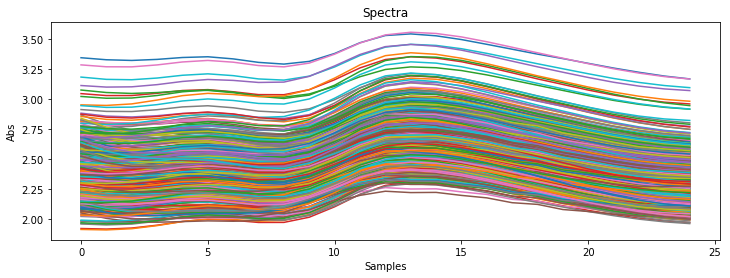

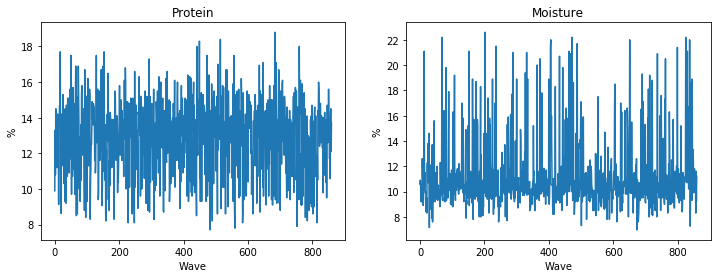

In [4]:
print(train_spectra.shape)
print(train_values[0].shape)
print(np.argwhere(np.isnan(train_values[0])))
print(np.argwhere(np.isnan(train_values[1])))
print(np.argwhere(np.isnan(train_values[2])))

plt.rcParams['figure.figsize'] = (12.0, 4.0) # set default size of plots
plt.plot(train_spectra.T)
plt.title('Spectra')
plt.ylabel('Abs')
plt.xlabel('Samples')
plt.show()

plt.subplot(121)
plt.plot(train_values[0])
plt.title(Cal1Name)
plt.ylabel('%')
plt.xlabel('Wave')

plt.subplot(122)
plt.plot(train_values[1])
plt.title(Cal2Name)
plt.ylabel('%')
plt.xlabel('Wave')
plt.show()

#### Principal Component Analysis (PCA) on training set

#### Data scaled to (-1,1) with MinMaxScaler

In [5]:
calibration_mean = train_spectra.mean(axis=0)
calibration_std = train_spectra.std(axis=0)

pca_components = 14

pca = PCA(n_components=pca_components)
pca.fit(train_spectra)
train_spectra_pca = pca.transform(train_spectra)

#train_spectra_norm = train_spectra.copy()
#train_spectra_norm = (train_spectra_norm - calibration_mean)/calibration_std

scaler = MinMaxScaler(feature_range=(-1,1))
train_spectra_pca = scaler.fit_transform(train_spectra_pca)

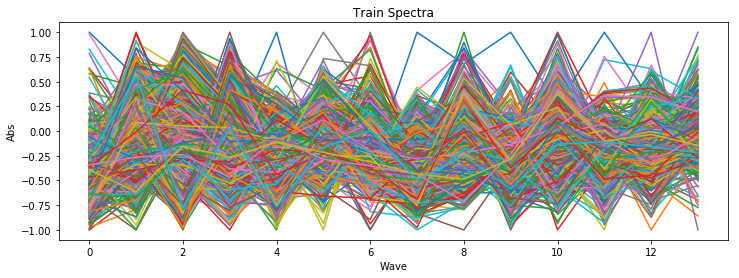

In [6]:
plt.plot(train_spectra_pca.T)
plt.title('Train Spectra')
plt.ylabel('Abs')
plt.xlabel('Wave')
plt.show()

### Validation Data

In [7]:
#Validation Data
path = "./Data/(2) Validation/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_val = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3"
df_val = df_val.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_val = df_val.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})

#randomise rows
df_val = df_val.sample(frac=1).reset_index(drop=True)

#Drop values of spectra if NaN
for i in range(9,33):
    df_val = df_val.dropna(subset=["Sp{}".format(i)])
    
#Drop lab values if NaN
df_val = df_val.dropna(subset=[Cal1Name])
df_val = df_val[df_val.Protein < Cal1MaxValue]
df_val = df_val[df_val.Protein > Cal1MinValue]
if "Exclude" in df_val:
    df_val = df_val[df_val.Exclude != 'Y']

val_spectra = df_val.loc[:,"Sp9":"Sp33"].values
val_spectra_norm = val_spectra.copy()

val_values = [1,2,3]
if Cal1Name in df_train:
    val_values[0] = df_val[Cal1Name].values
if Cal2Name in df_train:
    val_values[1] = df_val[Cal2Name].values
if Cal3Name in df_train:
    val_values[2] = df_val[Cal3Name].values
    
df_val.head()

,SampleID,Sp1*,Sp2*,Sp3*,Sp4*,Sp5*,Sp6*,Sp7*,Sp8*,Sp9,...,Sp34*,Sp35*,Sp36*,Sp37*,Sp38*,Protein,Moisture,Exclude,Exclude.1,Exclude.2
0,12618.13.5,3.08735,2.98565,2.89864,2.82682,2.76111,2.69948,2.63751,2.57743,2.52658,...,2.34301,2.37229,2.46770,2.64606,2.87397,13.8,9.9,N,N,N
1,W205,3.10836,3.02774,2.97479,2.93097,2.91407,2.84840,2.75653,2.65091,2.55573,...,2.33234,2.36057,2.43890,2.58328,2.76810,13.5,10.8,N,N,N
2,GC214083,2.55749,2.51518,2.47956,2.44992,2.42360,2.39859,2.37291,2.34851,2.33062,...,2.35478,2.37580,2.44364,2.57751,2.75972,11.1,10.7,N,N,N
3,W4A,2.84276,2.77404,2.73332,2.70222,2.69812,2.64520,2.56585,2.47222,2.38881,...,2.28342,2.31406,2.39382,2.53808,2.71997,14.5,11.4,N,N,N
4,133,3.03353,2.95851,2.91054,2.87142,2.85936,2.79941,2.71334,2.61295,2.52235,...,2.34470,2.37695,2.45963,2.60971,2.79832,15.6,13.9,N,N,N


(229, 25)
(229,)
[]


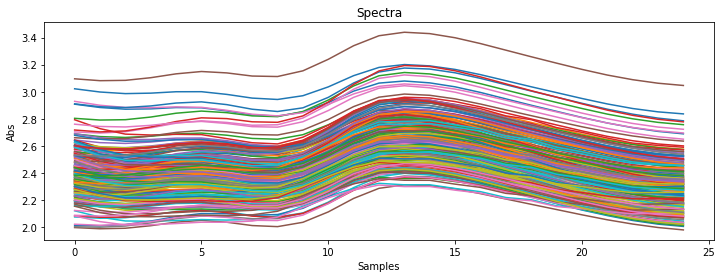

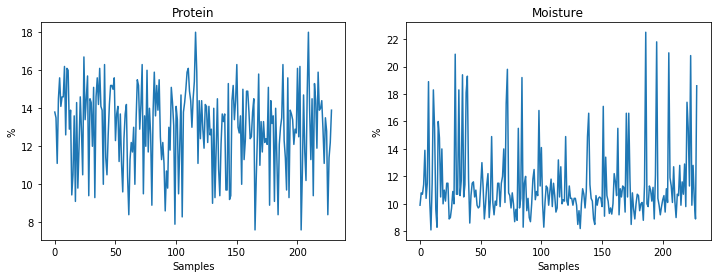

In [8]:
print(val_spectra.shape)
print(val_values[0].shape)
print(np.argwhere(np.isnan(val_values[0])))

plt.plot(val_spectra.T)
plt.title('Spectra')
plt.ylabel('Abs')
plt.xlabel('Samples')
plt.show()

plt.subplot(121)
plt.plot(val_values[0])
plt.title(Cal1Name)
plt.ylabel('%')
plt.xlabel('Samples')

plt.subplot(122)
plt.plot(val_values[1])
plt.title(Cal2Name)
plt.ylabel('%')
plt.xlabel('Samples')
plt.show()

In [9]:
val_spectra_pca = pca.transform(val_spectra)
print(val_spectra_pca.shape)

val_spectra_norm = val_spectra.copy()
val_spectra_norm = (val_spectra_norm - calibration_mean)/calibration_std

val_spectra_pca = scaler.transform(val_spectra_pca)

(229, 14)


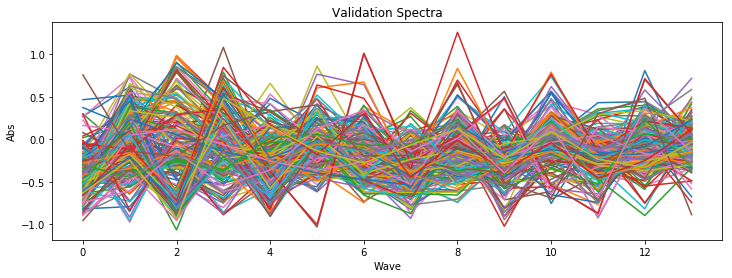

In [10]:
plt.plot(val_spectra_pca.T[:])
plt.title('Validation Spectra')
plt.ylabel('Abs')
plt.xlabel('Wave')
plt.show()

### TensorFlow model
- Input layer = 14 nodes from the 14 principal components
- Hidden layer = 5 nodes with L2 regularization and an `tanh` activation function for slower learning
- Output layer = single node with ReLU activation function

model1 is used for the first constituent (Protein) whereas model2 is used for the second constituent (Moisture). Even though both models will have the same hyperparameters, the weights must be tailored specifically to only their particular output

In [11]:
model1 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(pca_components, input_dim = pca_components, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(5, kernel_initializer='normal', activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Dense(1, activation='relu')
])

model2 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(pca_components, input_dim = pca_components, kernel_initializer='normal', activation='relu'),
  tf.keras.layers.Dense(5, kernel_initializer='normal', activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
  tf.keras.layers.Dense(1, activation='relu')
])

optimizer = tf.keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model1.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','acc'])
model2.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae','acc'])

In [12]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 14)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [13]:
%%time

#Fit the first model for Cal1
hist1 = model1.fit(train_spectra_pca, train_values[0], epochs=2000, verbose=0, validation_data=(val_spectra_pca,val_values[0]))

Wall time: 29.4 s


In [14]:
%%time

#Fit the second model for Cal2
hist2 = model2.fit(train_spectra_pca, train_values[1], epochs=2000, verbose=0, validation_data=(val_spectra_pca,val_values[1]))

Wall time: 29.2 s


In [15]:
print("{} Evaluation".format(Cal1Name))
print(model1.evaluate(val_spectra_pca, val_values[0]))
print("\n{} Evaluation".format(Cal2Name))
print(model2.evaluate(val_spectra_pca, val_values[1]))

Protein Evaluation
229/229 [==============================] - 0s 13us/step
[0.15342950235287695, 0.2843425220537394, 0.09170305676855896]

Moisture Evaluation
229/229 [==============================] - 0s 13us/step
[0.078990916758125, 0.17823356090674755, 0.1091703056768559]


In the first 100 epochs, the loss is very high, therefore the history plot starts from epoch 101

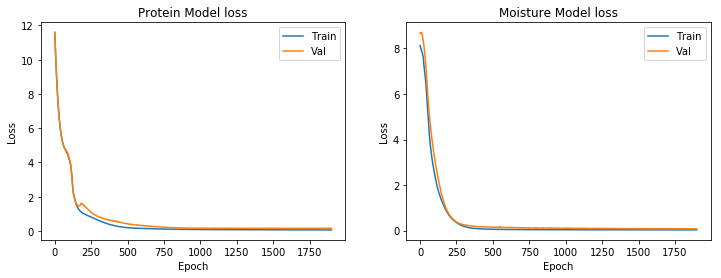

In [16]:
plt.subplot(121)
plt.plot(hist1.history['loss'][100:])
plt.plot(hist1.history['val_loss'][100:])
plt.title('{} Model loss'.format(Cal1Name))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')

plt.subplot(122)
plt.plot(hist2.history['loss'][100:])
plt.plot(hist2.history['val_loss'][100:])
plt.title('{} Model loss'.format(Cal2Name))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [17]:
prediction = [1,2,3]
prediction[0] = model1.predict(val_spectra_pca)
prediction[1] = model2.predict(val_spectra_pca)

In [18]:
np.savetxt("./Model Prediction.csv", prediction[0], delimiter=',')

In [19]:
#Testing Data
path = "./Data/(3) Testing/"
all_files = glob.glob(os.path.join(path, "*.csv")) #make list of paths

li = []

for filename in all_files:
    dfn = pd.read_csv(filename, index_col=None, header=0)
    li.append(dfn)

df_test = pd.concat(li, axis=0, ignore_index=True, sort=False)

#rename "cal1" "cal2" "cal3"
df_test = df_test.rename(index=str, columns={"Cal1": Cal1Name, "Cal2": Cal2Name, "Cal3": Cal3Name})
df_test = df_test.rename(index=str, columns={"cal1": Cal1Name, "cal2": Cal2Name, "cal3": Cal3Name})

#Drop values of spectra if NaN
for i in range(9,33):
    df_test = df_test.dropna(subset=["Sp{}".format(i)])
    
#Drop values of protein if NaN
df_test = df_test.dropna(subset=[Cal1Name])

test_spectra = df_test.loc[:,"Sp9":"Sp33"].values
                         
test_values = [1,2,3]
if Cal1Name in df_train:
    test_values[0] = df_test[Cal1Name].values
if Cal2Name in df_train:
    test_values[1] = df_test[Cal2Name].values
if Cal3Name in df_train:
    test_values[2] = df_test[Cal3Name].values

test_spectra_pca = pca.transform(test_spectra)

test_spectra_pca = scaler.transform(test_spectra_pca)

prediction[0] = model1.predict(test_spectra_pca)
prediction[1] = model2.predict(test_spectra_pca)

In [20]:
print("Lab Values {} = {}".format(Cal1Name, test_values[0]))
print("Prediction {} = {}\n".format(Cal1Name, np.around(prediction[0].reshape(test_values[0].shape[0]),decimals=1)))
print("Lab Values {} = {}".format(Cal2Name, test_values[1]))
print("Prediction {} = {}".format(Cal2Name, np.around(prediction[1].reshape(test_values[1].shape[0]),decimals=1)))

Lab Values Protein = [ 9.2  9.2 10.4 10.4 11.3 11.3 12.2 12.2 12.9 12.9 13.4 13.4 14.3 14.3
 15.2 15.2 16.2 16.2]
Prediction Protein = [10.7 10.8 11.3 11.4 12.4 12.7 13.2 13.1 14.5 14.5 14.3 14.3 15.4 15.3
 16.6 16.5 17.3 17.2]

Lab Values Moisture = [11.  11.   9.6  9.6 10.6 10.6  9.8  9.8  9.8  9.8 11.1 11.1 11.6 11.6
  9.9  9.9  9.3  9.3]
Prediction Moisture = [11.  11.   9.4  9.4 10.1 10.1  9.5  9.5  9.5  9.5 11.1 11.1 11.4 11.4
  9.8  9.7  9.4  9.5]


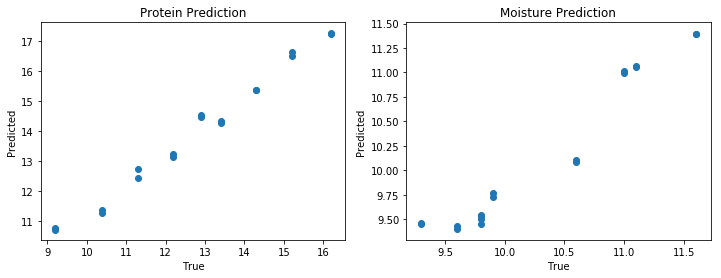

In [21]:
plt.subplot(121)
plt.scatter(test_values[0], prediction[0])
plt.title('Protein Prediction')
plt.ylabel('Predicted')
plt.xlabel('True')

plt.subplot(122)
plt.scatter(test_values[1], prediction[1])
plt.title('Moisture Prediction')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

In [22]:
def PrintResults(Name, constituent, useSlope = True, slope = 1.0):    
    print("Results for {}".format(Name))    

    if useSlope:
        LR_X = prediction[constituent][:,0].reshape(prediction[constituent][:,0].shape[0],1)
        LR_y = test_values[constituent].reshape(test_values[constituent].shape[0],1)
        reg = LinearRegression().fit(LR_X, LR_y)
        print ("R2 = " + str(reg.score(LR_X, LR_y)))

        print("Slope = " + str(reg.coef_))
        print("Bias = " + str(reg.intercept_))
        predictionAdjusted = prediction[constituent][:,0] * reg.coef_ + reg.intercept_
        predictionAdjusted = predictionAdjusted[0]
        
    else:
        predictionAdjusted = prediction[constituent][:,0] * slope
        bias = np.mean(predictionAdjusted - test_values[constituent])
        predictionAdjusted = predictionAdjusted - bias
        print("Slope = " + str(slope))
        print("Bias = " + str(bias))
        
    print("Lab Values = {}".format(np.round(test_values[constituent],1)))
    print("Prediction = {}".format(np.round(predictionAdjusted,1)))

    error = (predictionAdjusted - test_values[constituent])
    print("Error = {}".format(np.round(error,2)))

    sep = error.std()
    print("Standard Deviation = " + str(sep))
    
    plt.plot(error)
    plt.title('Prediction Error')
    plt.ylabel('Error %')
    plt.show()

Results for Protein
R2 = 0.9853972028051203
Slope = [[1.012549]]
Bias = [-1.3625708]
Lab Values = [ 9.2  9.2 10.4 10.4 11.3 11.3 12.2 12.2 12.9 12.9 13.4 13.4 14.3 14.3
 15.2 15.2 16.2 16.2]
Prediction = [ 9.5  9.6 10.  10.1 11.2 11.5 12.  11.9 13.3 13.3 13.2 13.1 14.2 14.2
 15.5 15.3 16.1 16.1]
Error = [ 0.3   0.35 -0.35 -0.25 -0.07  0.24 -0.17 -0.26  0.44  0.38 -0.25 -0.33
 -0.1  -0.12  0.27  0.13 -0.07 -0.13]
Standard Deviation = 0.25876656466617654


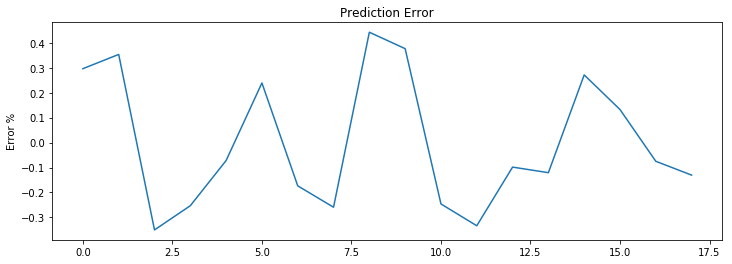

In [23]:
PrintResults(Cal1Name,0)

Results for Moisture
Slope = 1.0
Bias = -0.16857159932454438
Lab Values = [11.  11.   9.6  9.6 10.6 10.6  9.8  9.8  9.8  9.8 11.1 11.1 11.6 11.6
  9.9  9.9  9.3  9.3]
Prediction = [11.2 11.2  9.6  9.6 10.2 10.3  9.7  9.6  9.7  9.7 11.2 11.2 11.6 11.6
  9.9  9.9  9.6  9.6]
Error = [ 0.18  0.16  0.   -0.03 -0.35 -0.33 -0.13 -0.18 -0.09 -0.1   0.14  0.12
 -0.03 -0.04  0.03 -0.01  0.32  0.33]
Standard Deviation = 0.18342923219350082


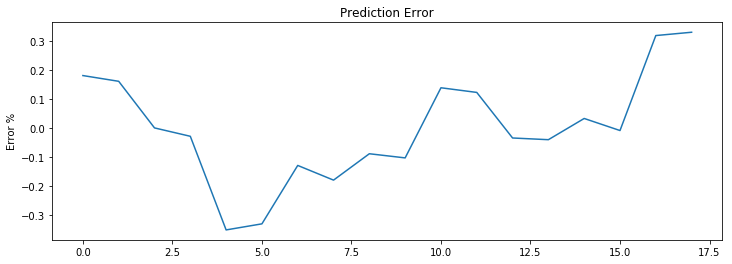

In [24]:
PrintResults(Cal2Name,1,False)

In [25]:
import json
json_string = model1.to_json()
print(json.dumps(json_string, indent=3))

"{\"class_name\": \"Sequential\", \"config\": [{\"class_name\": \"Dense\", \"config\": {\"name\": \"dense\", \"trainable\": true, \"batch_input_shape\": [null, 14], \"dtype\": \"float32\", \"units\": 14, \"activation\": \"relu\", \"use_bias\": true, \"kernel_initializer\": {\"class_name\": \"RandomNormal\", \"config\": {\"mean\": 0.0, \"stddev\": 1.0, \"seed\": null, \"dtype\": \"float32\"}}, \"bias_initializer\": {\"class_name\": \"Zeros\", \"config\": {\"dtype\": \"float32\"}}, \"kernel_regularizer\": null, \"bias_regularizer\": null, \"activity_regularizer\": null, \"kernel_constraint\": null, \"bias_constraint\": null}}, {\"class_name\": \"Dense\", \"config\": {\"name\": \"dense_1\", \"trainable\": true, \"dtype\": \"float32\", \"units\": 5, \"activation\": \"tanh\", \"use_bias\": true, \"kernel_initializer\": {\"class_name\": \"RandomNormal\", \"config\": {\"mean\": 0.0, \"stddev\": 1.0, \"seed\": null, \"dtype\": \"float32\"}}, \"bias_initializer\": {\"class_name\": \"Zeros\", \"

In [26]:
model1.save("./Model/Protein.h5")
model2.save("./Model/Moisture.h5")

In [27]:
import pickle
pkl_filename = "./Model/pickle_pca_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(pca, file)
    
pkl_filename = "./Model/pickle_scaler_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(scaler, file)